# Image Classification Model with Convolutional Neural Netwrok

## Background

This project proposes the development of an automated plant disease detection system using Convolutional Neural Networks (CNNs). Plant diseases are a major challenge to agricultural productivity and global food security, and traditional diagnosis methods often rely on expert knowledge, making them time-consuming, costly, and prone to error. By applying deep learning and computer vision techniques, the project aims to classify plant leaf images as healthy or diseased using image data.

The primary objective of the project is to design, train, and evaluate a CNN-based image classification model capable of accurately detecting plant diseases. The project workflow includes data collection and preprocessing, image augmentation, model development, and performance evaluation using standard metrics such as accuracy, precision, recall, F1-score, and confusion matrices. Additionally, the project compares a custom-built CNN with transfer learning models such as MobileNetV2 or ResNet50 to assess improvements in accuracy and efficiency.

The project is significant for farmers, agricultural extension workers, researchers, and students by providing a low-cost, accessible tool for early disease detection and decision support. Although the scope is limited to image-based classification using controlled datasets, the project contributes to the advancement of smart agriculture and demonstrates the practical application of deep learning in addressing real-world challenges related to sustainable farming and food security.


# Data source 
 A summary of the data has to be summarized here...

## Packages download

In [1]:
import pandas as pd
import numpy as np
import warnings
import mlflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

d:\data_science_dir\image_clasification_model\.venv\Lib\site-packages\mlflow\utils\requirements_utils.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
import sys, tensorflow as tf
print("Python:", sys.executable)
print("TensorFlow version:", getattr(tf, "__version__", "NO_VERSION"))
print("TensorFlow file:", getattr(tf, "__file__", "NO_FILE"))
print("Has tf.keras:", hasattr(tf, "keras"))


Python: d:\data_science_dir\image_clasification_model\.venv\Scripts\python.exe
TensorFlow version: 2.15.0
TensorFlow file: d:\data_science_dir\image_clasification_model\.venv\Lib\site-packages\tensorflow\__init__.py
Has tf.keras: True


## Data loading and EDA

In [3]:
from pathlib import Path
data_dir = Path("PlantVillage")
print(data_dir.exists(), data_dir.resolve())
classes = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
print("Classes:", classes)
print("Number of classes:", len(classes))


True D:\data_science_dir\image_clasification_model\PlantVillage
Classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites_Two_spotted_spider_mite', 'Target_Spot', 'YellowLeaf__Curl_Virus', 'healthy', 'mosaic_virus']
Number of classes: 10


In [4]:
counts = []
for c in classes:
    n = len(list((data_dir / c).glob("*.jpg"))) + len(list((data_dir / c).glob("*.png"))) + len(list((data_dir / c).glob("*.jpeg")))
    counts.append((c, n))

df_counts = pd.DataFrame(counts, columns=["class", "num_images"]).sort_values("num_images", ascending=False)
df_counts

,class,num_images
8,healthy,3221
7,YellowLeaf__Curl_Virus,3208
0,Bacterial_spot,3124
2,Late_blight,2909
1,Early_blight,2000
4,Septoria_leaf_spot,1771
5,Spider_mites_Two_spotted_spider_mite,1676
6,Target_Spot,1404
3,Leaf_Mold,952
9,mosaic_virus,373


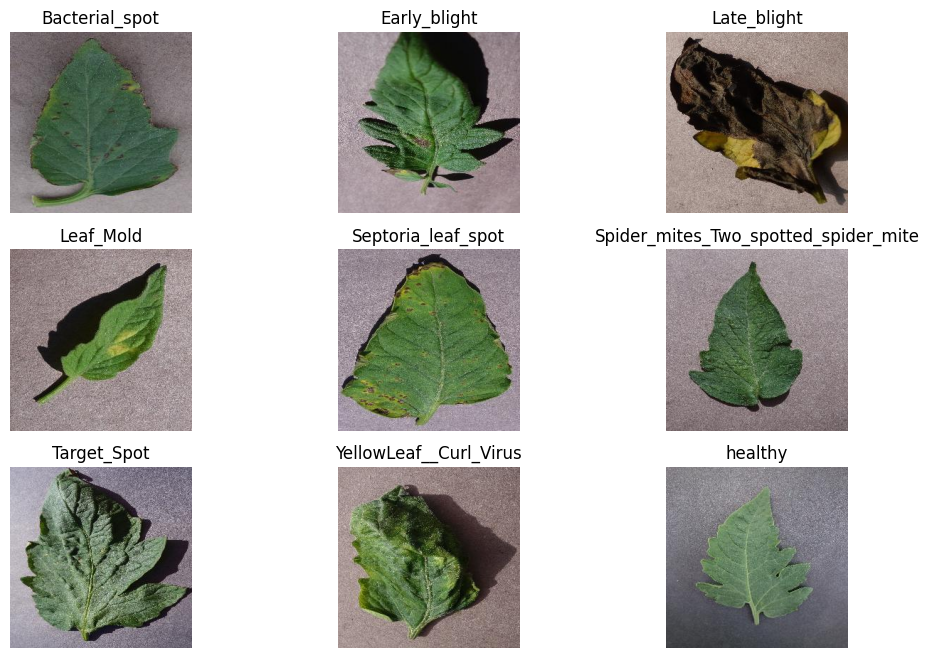

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image

sample_paths = []
for c in classes:
    imgs = list((data_dir / c).glob("*.jpg")) + list((data_dir / c).glob("*.png")) + list((data_dir / c).glob("*.jpeg"))
    if imgs:
        sample_paths.append(random.choice(imgs))

plt.figure(figsize=(12, 8))
for i, p in enumerate(sample_paths[:9]):
    img = Image.open(p)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(p.parent.name)
    plt.axis("off")
plt.show()


## Create train/validation datasets from folders

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 20638 files belonging to 10 classes.
Using 16511 files for training.
Found 20638 files belonging to 10 classes.
Using 4127 files for validation.
Class names: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites_Two_spotted_spider_mite', 'Target_Spot', 'YellowLeaf__Curl_Virus', 'healthy', 'mosaic_virus']


## Splitting data for testing 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_train["altitude_mean_log"] = np.log(X_train["altitude_mean_meters"])
X_train.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_train.drop(['Quakers'], axis=1, inplace=True)
X_train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
X_train.info()

In [ ]:
altitude_low_meters_mean = X_train["altitude_low_meters"].mean()
altitude_high_meters_mean = X_train["altitude_high_meters"].mean()
altitude_mean_log_mean = X_train["altitude_mean_log"].mean()

In [ ]:
# fillna with mean.. 
X_train["altitude_low_meters"] = X_train["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_train["altitude_high_meters"] = X_train["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_train["altitude_mean_log"] = X_train["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [ ]:
print(f"altitude low meters mean is {altitude_low_meters_mean}")
print(f"altitude_high_meters_mean is {altitude_high_meters_mean}")
print(f"altitude_mean_log_mean is {altitude_mean_log_mean}")

## Trainining the model and tracking with MLFlow

In [ ]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [ ]:
print("Active run_id: {}".format(run.info.run_id))

In [ ]:
#training the model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
#model metric on training data
from sklearn.metrics import mean_squared_error
y_train_pred = reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print(mse_train)

In [ ]:
# feature engineering of test data
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_test["altitude_mean_log"] = np.log(X_test["altitude_mean_meters"])
X_test.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_test.drop(['Quakers'], axis=1, inplace=True)
X_test.drop(['Unnamed: 0'], axis=1, inplace=True)
# fillna with mean.. 
X_test["altitude_low_meters"] = X_test["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_test["altitude_high_meters"] = X_test["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_test["altitude_mean_log"] = X_test["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [ ]:
#model metric on test data
y_test_pred = reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(mse_test)

In [ ]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "altitude_low_meters_mean": altitude_low_meters_mean,
      "altitude_high_meters_mean": altitude_high_meters_mean,
      "altitude_mean_log_mean": altitude_mean_log_mean,
      "fit_intercept": True,
  }

In [ ]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "MSE", mse_train)
mlflow.log_metric("test-" + "MSE", mse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

In [ ]:
mlflow.get_run(run_id=run.info.run_id)

## Checking the experiments

while the next cell is running you will not be able to run other cells in the notebook

In [5]:
!mlflow ui

^C
